OhioT1DM Dataset - Blood Glucose Level Prediction

[https://pmc.ncbi.nlm.nih.gov/articles/PMC7881904/](https://pmc.ncbi.nlm.nih.gov/articles/PMC7881904/)

In [1]:
!pip install numpy pandas tensorflow matplotlib seaborn scipy kagglehub

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xml.etree.ElementTree as ET
import glob
from scipy.interpolate import interp2d

# 시각화 스타일 설정
sns.set()

In [3]:
# kagglehub로 다운로드한 파일을 현재 작업 폴더로 복사
import kagglehub
import shutil
import os

# 데이터셋 다운로드 (캐시에 저장됨)
print("Ohio 데이터셋을 다운로드 중입니다...")
cache_path = kagglehub.dataset_download("ryanmouton/ohio-data-set")
print(f"캐시 경로: {cache_path}")

# 현재 작업 디렉토리 내에 데이터 폴더 생성
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "ohio_data")
os.makedirs(data_dir, exist_ok=True)

# 캐시에서 현재 작업 폴더로 파일 복사
print(f"파일을 {data_dir}로 복사 중...")

# 전체 디렉토리 구조 복사
for root, dirs, files in os.walk(cache_path):
    # 대상 디렉토리 경로 생성
    rel_path = os.path.relpath(root, cache_path)
    dest_dir = os.path.join(data_dir, rel_path)
    os.makedirs(dest_dir, exist_ok=True)
    
    # 파일 복사
    for file in files:
        src_file = os.path.join(root, file)
        dest_file = os.path.join(dest_dir, file)
        shutil.copy2(src_file, dest_file)

print(f"파일이 {data_dir}로 복사되었습니다.")

# xml_path 설정 (복사된 경로 기준)
xml_path = os.path.join(data_dir, "OhioT1DM-training")

# 복사된 파일 구조 확인
print("복사된 파일 구조:")
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for file in files[:5]:  # 각 디렉토리의 처음 5개 파일만 표시
        print(f"{sub_indent}{file}")
    if len(files) > 5:
        print(f"{sub_indent}... 외 {len(files)-5}개 파일")

c:\Users\inhag\.virtualenvs\Chapter6-JcyiWNwd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ohio 데이터셋을 다운로드 중입니다...
캐시 경로: C:\Users\inhag\.cache\kagglehub\datasets\ryanmouton\ohio-data-set\versions\1
파일을 c:\Users\inhag\DoctorCode-Workbook\Chapter6\ohio_data로 복사 중...
파일이 c:\Users\inhag\DoctorCode-Workbook\Chapter6\ohio_data로 복사되었습니다.
복사된 파일 구조:
ohio_data/
    OhioT1DM/
        2018/
            test/
                559-ws-testing.xml
                563-ws-testing.xml
                570-ws-testing.xml
                575-ws-testing.xml
                588-ws-testing.xml
                ... 외 1개 파일
            train/
                559-ws-training.xml
                563-ws-training.xml
                570-ws-training.xml
                575-ws-training.xml
                588-ws-training.xml
                ... 외 1개 파일
        2020/
            test/
                540-ws-testing.xml
                544-ws-testing.xml
                552-ws-testing.xml
                567-ws-testing.xml
                584-ws-testing.xml
                ... 외 1개 파일
            train/
     

#### 1. 유틸리티 함수 정의

In [4]:
# 시퀀스를 윈도우로 나누는 함수
def rolling_window(sequence, window):
    """시퀀스를 윈도우 크기로 나눕니다."""
    shape = sequence.shape[:-1] + (sequence.shape[-1] - window + 1, window)
    strides = sequence.strides + (sequence.strides[-1],)
    return np.lib.stride_tricks.as_strided(sequence, shape=shape, strides=strides)

# 시퀀스를 지도학습 형태로 변환하는 함수
def sequence_to_supervised(data, nb_past_steps, nb_steps_in_future):
    """시퀀스 데이터를 특성(과거 데이터)과 타겟(미래 데이터)으로 변환합니다."""
    x = rolling_window(data, nb_past_steps)
    y = data[nb_past_steps+nb_steps_in_future-1::1]
    
    x, y = zip(*zip(x, y))
    
    return np.array(x), np.array(y)

# 데이터를 훈련, 검증, 테스트 세트로 나누는 함수
def split_data(xs, train_fraction, valid_fraction, test_fraction):
    """데이터를 훈련, 검증, 테스트 세트로 분할합니다."""
    n = len(xs)
    nb_train = int(np.ceil(train_fraction*n))
    nb_valid = int(np.ceil(valid_fraction*n))
    i_end_train = nb_train
    i_end_valid = nb_train+nb_valid
    
    return np.split(xs, [i_end_train, i_end_valid])

#### 2. 데이터 로드 함수

In [5]:
# Ohio 데이터셋의 시계열 로드 함수
def load_ohio_series(xml_path, variate_name, attribute, time_attribue="ts"):
    """XML 파일에서 시계열 데이터를 로드합니다."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for child in root:
        if child.tag == variate_name:
            dates = []
            values = []
            for event in child:
                ts = event.attrib[time_attribue]
                date = pd.to_datetime(ts, format='%d-%m-%Y %H:%M:%S')
                date = date.replace(second=0)
                value = float(event.attrib[attribute])
                dates.append(date)
                values.append(value)
            index = pd.DatetimeIndex(dates)
            series = pd.Series(values, index=index)
            return series

# 혈당 데이터 로드 함수
def load_glucose_data(xml_path, nb_past_steps, nb_future_steps):
    """XML 파일에서 혈당 데이터를 로드하고 지도학습 형태로 변환합니다."""
    df_glucose_level = load_ohio_series(xml_path, "glucose_level", "value")
    dt = df_glucose_level.index.to_series().diff().dropna()
    idx_breaks = np.argwhere(dt!=pd.Timedelta(5, 'm'))
    
    # 혈당 수치를 numpy 배열로 변환
    nd_glucose_level = df_glucose_level.values
    consecutive_segments = np.split(nd_glucose_level, idx_breaks.flatten())
    
    # 필요한 길이의 연속 세그먼트만 선택
    consecutive_segments = [c for c in consecutive_segments if len(c) >= 
            nb_past_steps+nb_future_steps]
    
    # 각 세그먼트를 지도학습 형태로 변환
    sups = [sequence_to_supervised(c, nb_past_steps, nb_future_steps) for 
            c in consecutive_segments]
    
    xss = [sup[0] for sup in sups]
    yss = [sup[1] for sup in sups]
    
    xs = np.concatenate(xss)
    ys = np.concatenate(yss)
    
    return np.expand_dims(xs, axis=2), ys

# 단일 환자 데이터 로드 함수
def load_data(xml_path, nb_past_steps, nb_future_steps, train_fraction, valid_fraction, test_fraction, scale):
    """단일 환자의 데이터를 로드하고 전처리합니다."""
    xs, ys = load_glucose_data(xml_path, nb_past_steps, nb_future_steps)
    ys = np.expand_dims(ys, axis=1)
    
    # 데이터 분할
    x_train, x_valid, x_test = split_data(xs, train_fraction,
            valid_fraction, test_fraction)
    y_train, y_valid, y_test = split_data(ys, train_fraction,
            valid_fraction, test_fraction)
    
    # 데이터 스케일링
    x_train *= scale
    y_train *= scale
    x_valid *= scale
    y_valid *= scale
    x_test  *= scale
    y_test  *= scale
    
    return x_train, y_train, x_valid, y_valid, x_test, y_test

# Ohio 데이터셋 로드 함수 수정
def load_dataset(data_dir, nb_past_steps, nb_future_steps, train_fraction, valid_fraction, test_fraction, scale):
    """
    Ohio 데이터셋의 구조(연도별, train/test)에 맞게 데이터를 로드하고 병합합니다.
    """
    print("모든 환자의 훈련 데이터를 로드합니다...")
    
    # 연도별 디렉토리 탐색
    year_dirs = glob.glob(os.path.join(data_dir, "*"))
    print(f"발견된 연도 디렉토리: {[os.path.basename(d) for d in year_dirs]}")
    
    # 모든 연도의 train 디렉토리에서 XML 파일 수집
    train_xml_paths = []
    for year_dir in year_dirs:
        train_dir = os.path.join(year_dir, "train")
        if os.path.exists(train_dir):
            xml_files = glob.glob(os.path.join(train_dir, "*.xml"))
            train_xml_paths.extend(xml_files)
            print(f"{os.path.basename(year_dir)}년 훈련 XML 파일: {len(xml_files)}개")
    
    # 훈련 XML 파일이 없으면 종료
    if not train_xml_paths:
        print("오류: 훈련 XML 파일을 찾을 수 없습니다.")
        print("데이터셋 구조를 확인하세요.")
        return None, None, None, None, None, None
    
    print(f"총 {len(train_xml_paths)}개의 훈련 XML 파일을 발견했습니다.")
    
    # 각 XML 파일에서 데이터 로드
    tups = []
    for xml_path in train_xml_paths:
        print(f"파일 로드 중: {os.path.basename(xml_path)}")
        try:
            tup = load_data(xml_path, nb_past_steps, nb_future_steps, train_fraction, valid_fraction, test_fraction, scale)
            tups.append(tup)
            print(f"성공적으로 로드됨: {os.path.basename(xml_path)}")
        except Exception as e:
            print(f"파일 로드 실패: {os.path.basename(xml_path)}, 오류: {str(e)}")
    
    # 데이터 병합
    if tups:
        print("데이터 병합 중...")
        x_train = np.concatenate([t[0] for t in tups], axis=0)
        y_train = np.concatenate([t[1] for t in tups], axis=0)
        x_valid = np.concatenate([t[2] for t in tups], axis=0)
        y_valid = np.concatenate([t[3] for t in tups], axis=0)
        x_test = np.concatenate([t[4] for t in tups], axis=0)
        y_test = np.concatenate([t[5] for t in tups], axis=0)
        
        return x_train, y_train, x_valid, y_valid, x_test, y_test
    else:
        print("로드된 데이터가 없습니다.")
        return None, None, None, None, None, None

#### 3. 손실 함수 및 평가 지표

In [6]:
# 음의 로그 우도 손실 함수
def tf_nll(y_true, y_pred):
    """음의 로그 우도 손실 함수입니다."""
    y_var = y_pred[:,:1]  # 분산
    y_mean = y_pred[:,1:]  # 평균
    y_std = y_var  # 표준편차
    
    # TF 2.x에서는 다음과 같이 수정
    from tensorflow.keras import backend as K
    from tensorflow import math as tfm
    
    # 정규 분포 확률 밀도 함수 계산
    exponent = -0.5 * tfm.square((y_true - y_mean) / y_std)
    coefficient = 1.0 / (y_std * tfm.sqrt(2.0 * np.pi))
    probs = coefficient * tfm.exp(exponent)
    
    return K.mean(-tfm.log(K.epsilon() + probs))

# RMSE 계산 함수
def root_mean_squared_error(targets, predictions):
    """평균 제곱근 오차(RMSE)를 계산합니다."""
    return np.sqrt(np.mean(np.power(targets-predictions, 2)))

# 감시 오류 그리드(SEG) 계산 함수
def surveillance_error(targets, predictions):
    """감시 오류 그리드(SEG) 점수를 계산합니다."""
    # seg.csv 파일이 현재 디렉토리에 있다고 가정합니다
    data = np.loadtxt('seg.csv')
    
    xs = np.linspace(0, 600, data.shape[0])
    ys = np.linspace(0, 600, data.shape[1])
    f = interp2d(xs, ys, np.transpose(data))
    
    scores = np.concatenate([f(t, p) for (t, p) in zip(targets, predictions)])
    return np.mean(scores), np.std(scores)

#### 4. 모델 정의

In [7]:
# 활성화 함수 선택 함수
def get_activation_function_by_name(name='exp'):
    """이름으로 활성화 함수를 반환합니다."""
    if name == 'exp':
        return tf.exp
    elif name == 'softplus':
        return tf.math.softplus
    elif name == 'relu':
        return tf.nn.relu
    else:
        raise ValueError("지원되지 않는 활성화 함수입니다: {}".format(name))

# 모델 생성 함수
def create_model(input_shape, output_shape, nb_lstm_states=256, activation_function='exp'):
    """LSTM 기반 혈당 예측 모델을 생성합니다."""
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # TF 2.x에서는 CuDNNLSTM 대신 LSTM 사용
    x = tf.keras.layers.LSTM(units=nb_lstm_states, unit_forget_bias=True)(inputs)
    
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    mu = tf.keras.layers.Dense(1)(x)
    std = tf.keras.layers.Dense(1)(x)
    activation_fn = get_activation_function_by_name(activation_function)
    std = tf.keras.layers.Lambda(activation_fn, name="exponential_activation")(std)
    
    output = tf.keras.layers.Concatenate(axis=-1)([std, mu])
    model = tf.keras.models.Model(inputs=[inputs], outputs=[output])
    
    return model

#### 5. 학습 및 평가

In [8]:
# 매개변수 설정
# Ohio 데이터셋 경로 설정
ohio_data_dir = os.path.join("./ohio_data", "OhioT1DM")
nb_past_steps = 12
nb_future_steps = 6  # 6 또는 12
train_fraction = 0.8
valid_fraction = 0.2
test_fraction = 0.0
scale = 0.01
nb_lstm_states = 256
activation_function = 'exp'
learning_rate = 1e-3
batch_size = 1024
epochs = 100
patience = 20
shuffle = True
artifacts_path = './artifacts/'

# 디렉토리 생성
os.makedirs(artifacts_path, exist_ok=True)

# 데이터 로드
print("데이터를 로드 중입니다...")
x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(
    ohio_data_dir,
    nb_past_steps, 
    nb_future_steps, 
    train_fraction, 
    valid_fraction, 
    test_fraction, 
    scale
)

print("데이터 형태:")
print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_valid.shape: {x_valid.shape}")
print(f"y_valid.shape: {y_valid.shape}")

# 모델 생성
print("모델을 생성 중입니다...")
model = create_model(
    x_train.shape[1:],
    y_train.shape[1]*2,
    nb_lstm_states=nb_lstm_states,
    activation_function=activation_function
)

# 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=tf_nll)
model.summary()


데이터를 로드 중입니다...
모든 환자의 훈련 데이터를 로드합니다...
발견된 연도 디렉토리: ['2018', '2020']
2018년 훈련 XML 파일: 6개
2020년 훈련 XML 파일: 6개
총 12개의 훈련 XML 파일을 발견했습니다.
파일 로드 중: 559-ws-training.xml
성공적으로 로드됨: 559-ws-training.xml
파일 로드 중: 563-ws-training.xml
성공적으로 로드됨: 563-ws-training.xml
파일 로드 중: 570-ws-training.xml
성공적으로 로드됨: 570-ws-training.xml
파일 로드 중: 575-ws-training.xml
성공적으로 로드됨: 575-ws-training.xml
파일 로드 중: 588-ws-training.xml
성공적으로 로드됨: 588-ws-training.xml
파일 로드 중: 591-ws-training.xml
성공적으로 로드됨: 591-ws-training.xml
파일 로드 중: 540-ws-training.xml
성공적으로 로드됨: 540-ws-training.xml
파일 로드 중: 544-ws-training.xml
성공적으로 로드됨: 544-ws-training.xml
파일 로드 중: 552-ws-training.xml
성공적으로 로드됨: 552-ws-training.xml
파일 로드 중: 567-ws-training.xml
성공적으로 로드됨: 567-ws-training.xml
파일 로드 중: 584-ws-training.xml
성공적으로 로드됨: 584-ws-training.xml
파일 로드 중: 596-ws-training.xml
성공적으로 로드됨: 596-ws-training.xml
데이터 병합 중...
데이터 형태:
x_train.shape: (101816, 12, 1)
y_train.shape: (101816, 1)
x_valid.shape: (25449, 12, 1)
y_valid.shape: (25449, 1)
모델을 생성 중입니

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    264,192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    131,584 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ dense[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256)       │          0 │ dense_1[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exponential_activa… │ (None, 1)         │          0 │ dense_3[0][0]     │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ exponential_acti… │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 527,618 (2.01 MB)

 Trainable params: 527,618 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 콜백 설정 수정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir=artifacts_path
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(artifacts_path, "model.h5"),
        monitor='val_loss',  # 검증 손실 모니터링
        save_best_only=True,
        # save_weights_only=True,
        verbose=1,
        mode='min'  # 손실값이므로 최소화하는 방향
    )
]

# 모델 훈련 코드 수정
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),  # 검증 데이터 명시적으로 제공
    epochs=epochs,
    batch_size=batch_size,
    shuffle=shuffle,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


c:\Users\inhag\.virtualenvs\Chapter6-JcyiWNwd\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 12, 1))
  warnings.warn(msg)


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.8198
Epoch 1: val_loss improved from inf to 0.01649, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.8126 - val_loss: 0.0165
Epoch 2/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1116
Epoch 2: val_loss improved from 0.01649 to -0.02756, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.1113 - val_loss: -0.0276
Epoch 3/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0451
Epoch 3: val_loss improved from -0.02756 to -0.06083, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0449 - val_loss: -0.0608
Epoch 4/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0398
Epoch 4: val_loss improved from -0.06083 to -0.08277, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0393 - val_loss: -0.0828
Epoch 5/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.0224
Epoch 5: val_loss improved from -0.08277 to -0.08987, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.0223 - val_loss: -0.0899
Epoch 6/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.0349
Epoch 6: val_loss improved from -0.08987 to -0.13136, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.0349 - val_loss: -0.1314
Epoch 7/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.0507
Epoch 7: val_loss improved from -0.13136 to -0.15801, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.0508 - val_loss: -0.1580
Epoch 8/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: -0.0721
Epoch 8: val_loss did not improve from -0.15801
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.0722 - val_loss: -0.1344
Epoch 9/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.0816
Epoch 9: val_loss improved from -0.15801 to -0.17659, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.0817 - val_loss: -0.1766
Epoch 10/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.0936
Epoch 10: val_loss did not improve from -0.17659
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.0936 - val_loss: -0.1137
Epoch 11/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1056
Epoch 11: val_loss did not improve from -0.17659
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.1057 - val_loss: -0.1241
Epoch 12/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1052
Epoch 12: val_loss did not improve from -0.17659
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.1053 - val_loss: -0.1447
Epoch 13/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: -0.1105
Epoch 13: val_loss improved from -0.17659 to -0.19247, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.1105 - val_loss: -0.1925
Epoch 14/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: -0.1242
Epoch 14: val_loss did not improve from -0.19247
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.1243 - val_loss: -0.1495
Epoch 15/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1350
Epoch 15: val_loss did not improve from -0.19247
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1350 - val_loss: -0.1465
Epoch 16/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.1331
Epoch 16: val_loss improved from -0.19247 to -0.19540, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.1331 - val_loss: -0.1954
Epoch 17/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1466
Epoch 17: val_loss improved from -0.19540 to -0.21096, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1466 - val_loss: -0.2110
Epoch 18/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1447
Epoch 18: val_loss did not improve from -0.21096
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1448 - val_loss: -0.1896
Epoch 19/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1451
Epoch 19: val_loss did not improve from -0.21096
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.1452 - val_loss: -0.1932
Epoch 20/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: -0.1614
Epoch 20: val_loss did not improve from -0.21096
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.1614 - val_loss: -0.2054
Epoch 21/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1605
Epoch 21: val_loss improved from -0.21096 to -0.21837, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1605 - val_loss: -0.2184
Epoch 22/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: -0.1655
Epoch 22: val_loss did not improve from -0.21837
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.1655 - val_loss: -0.2120
Epoch 23/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1816
Epoch 23: val_loss did not improve from -0.21837
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1814 - val_loss: -0.2054
Epoch 24/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1751
Epoch 24: val_loss did not improve from -0.21837
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1751 - val_loss: -0.1867
Epoch 25/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1704
Epoch 25: val_loss did not improve from -0.21837
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1705 - val_loss: -0.2087
Epoch 26/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: -0.1782
Epoch 26: val_loss did not improve from -0.21837
100/100 ━━

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.1783 - val_loss: -0.2241
Epoch 28/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1848
Epoch 28: val_loss did not improve from -0.22414
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1848 - val_loss: -0.2135
Epoch 29/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: -0.1953
Epoch 29: val_loss improved from -0.22414 to -0.22746, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: -0.1952 - val_loss: -0.2275
Epoch 30/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1993
Epoch 30: val_loss did not improve from -0.22746
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1992 - val_loss: -0.2265
Epoch 31/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.1948
Epoch 31: val_loss improved from -0.22746 to -0.23702, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.1948 - val_loss: -0.2370
Epoch 32/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: -0.1989
Epoch 32: val_loss did not improve from -0.23702
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.1989 - val_loss: -0.2168
Epoch 33/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2066
Epoch 33: val_loss did not improve from -0.23702
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.2065 - val_loss: -0.2134
Epoch 34/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2035
Epoch 34: val_loss did not improve from -0.23702
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.2035 - val_loss: -0.2327
Epoch 35/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: -0.2079
Epoch 35: val_loss did not improve from -0.23702
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.2079 - val_loss: -0.2170
Epoch 36/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2095
Epoch 36: val_loss did not improve from -0.23702
100/100 ━━

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: -0.2251 - val_loss: -0.2388
Epoch 42/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2207
Epoch 42: val_loss improved from -0.23883 to -0.24310, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.2207 - val_loss: -0.2431
Epoch 43/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2221
Epoch 43: val_loss did not improve from -0.24310
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.2221 - val_loss: -0.2382
Epoch 44/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2211
Epoch 44: val_loss did not improve from -0.24310
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.2212 - val_loss: -0.2312
Epoch 45/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2236
Epoch 45: val_loss did not improve from -0.24310
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.2237 - val_loss: -0.2307
Epoch 46/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2317
Epoch 46: val_loss improved from -0.24310 to -0.24693, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.2317 - val_loss: -0.2469
Epoch 47/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2347
Epoch 47: val_loss did not improve from -0.24693
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.2346 - val_loss: -0.2236
Epoch 48/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2360
Epoch 48: val_loss did not improve from -0.24693
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.2361 - val_loss: -0.2280
Epoch 49/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2260
Epoch 49: val_loss did not improve from -0.24693
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.2261 - val_loss: -0.2387
Epoch 50/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2434
Epoch 50: val_loss did not improve from -0.24693
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: -0.2433 - val_loss: -0.2449
Epoch 51/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2358
Epoch 51: val_loss improved from -0.24693 to -0.25067, savi

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.2359 - val_loss: -0.2507
Epoch 52/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2439
Epoch 52: val_loss did not improve from -0.25067
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.2439 - val_loss: -0.2481
Epoch 53/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2435
Epoch 53: val_loss improved from -0.25067 to -0.25080, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: -0.2435 - val_loss: -0.2508
Epoch 54/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: -0.2312
Epoch 54: val_loss did not improve from -0.25080
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: -0.2314 - val_loss: -0.2360
Epoch 55/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2372
Epoch 55: val_loss did not improve from -0.25080
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.2373 - val_loss: -0.2459
Epoch 56/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.2541
Epoch 56: val_loss did not improve from -0.25080
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.2540 - val_loss: -0.2429
Epoch 57/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: -0.2494
Epoch 57: val_loss did not improve from -0.25080
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: -0.2493 - val_loss: -0.2435
Epoch 58/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: -0.2522
Epoch 58: val_loss did not improve from -0.25080
100/100 ━━

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.2497 - val_loss: -0.2510
Epoch 64/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2472
Epoch 64: val_loss improved from -0.25096 to -0.25273, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.2473 - val_loss: -0.2527
Epoch 65/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2600
Epoch 65: val_loss did not improve from -0.25273
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.2599 - val_loss: -0.2451
Epoch 66/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: -0.2611
Epoch 66: val_loss did not improve from -0.25273
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.2610 - val_loss: -0.2504
Epoch 67/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: -0.2581
Epoch 67: val_loss did not improve from -0.25273
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: -0.2581 - val_loss: -0.2518
Epoch 68/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2637
Epoch 68: val_loss improved from -0.25273 to -0.26228, saving model to ./artifacts/model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.2636 - val_loss: -0.2623
Epoch 69/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2588
Epoch 69: val_loss did not improve from -0.26228
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: -0.2588 - val_loss: -0.2527
Epoch 70/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2601
Epoch 70: val_loss did not improve from -0.26228
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.2601 - val_loss: -0.2506
Epoch 71/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2675
Epoch 71: val_loss did not improve from -0.26228
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.2674 - val_loss: -0.2549
Epoch 72/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2698
Epoch 72: val_loss did not improve from -0.26228
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: -0.2697 - val_loss: -0.2493
Epoch 73/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: -0.2607
Epoch 73: val_loss did not improve from -0.26228
100/100 ━━

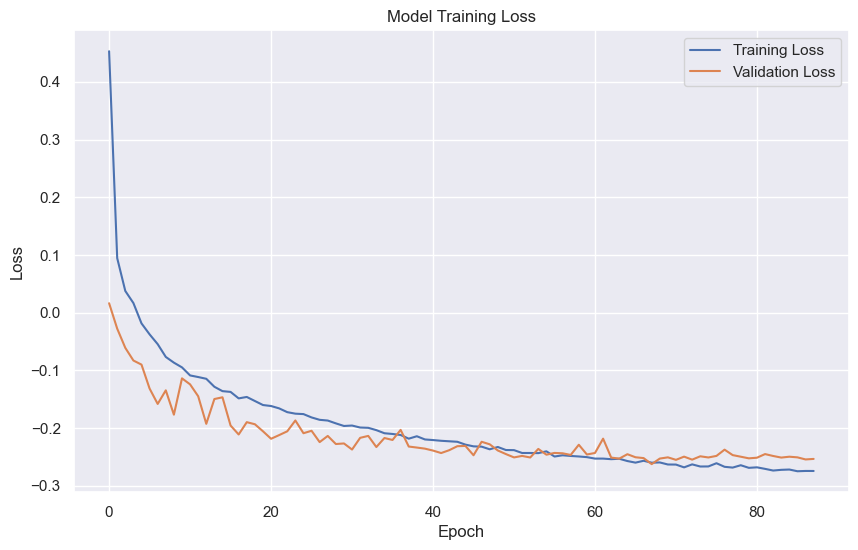

모델 평가를 시작합니다...
796/796 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
RMSE: 21.479846808526315


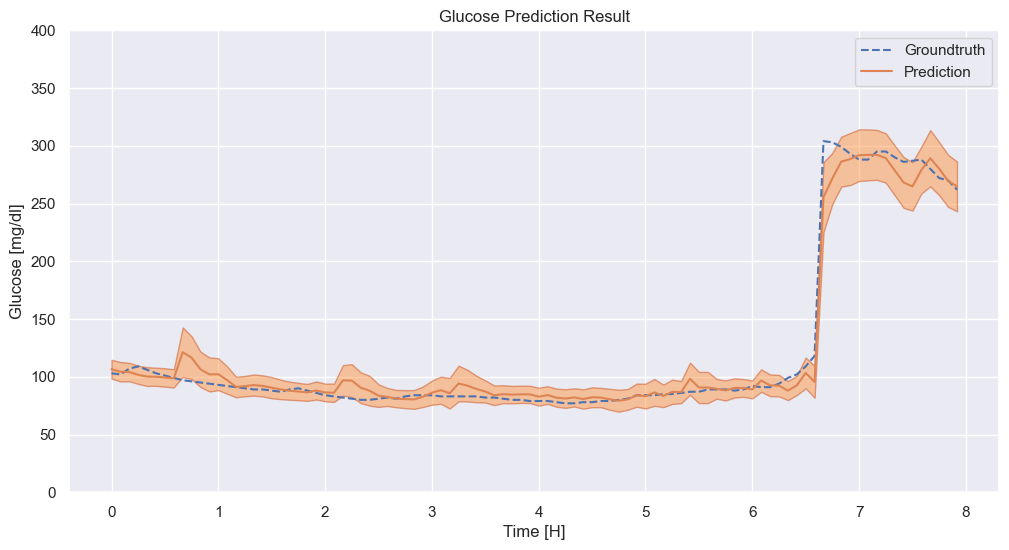

SEG 시각화 중 오류 발생: seg.csv not found.
seg.csv 파일이 현재 디렉토리에 있는지 확인하세요.


In [12]:
# 훈련 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(artifacts_path, 'training_loss.png'))
plt.show()

# 모델 평가
print("모델 평가를 시작합니다...")
# 베스트 모델 로드
model.load_weights(os.path.join(artifacts_path, "model.h5"))

# 예측 수행
y_pred = model.predict(x_valid)
y_pred_mean = y_pred[:,1].flatten()/scale  # 예측 평균
y_pred_std = y_pred[:,0].flatten()/scale   # 예측 표준편차
y_valid_flat = y_valid.flatten()/scale     # 실제값

# RMSE 계산
rmse = root_mean_squared_error(y_valid_flat, y_pred_mean)
print(f"RMSE: {rmse}")

# 예측 결과 시각화 (첫 8시간)
hours = 8
to_plot = hours * 12  # 5분 간격으로 8시간 = 96 데이터 포인트
ticks_per_hour = 12
ticks = [i*ticks_per_hour for i in range(hours+1)]
ticks_labels = [str(i) for i in range(hours+1)]

# 시각화할 인덱스 범위
start_index = 0
end_index = min(start_index + to_plot, len(y_valid_flat))

# 데이터 준비
y_true = y_valid_flat[start_index:end_index]
y_mean = y_pred_mean[start_index:end_index]
y_std = y_pred_std[start_index:end_index]
xs = np.arange(len(y_true))

# 예측 결과 플롯
plt.figure(figsize=(12, 6))
plt.plot(xs, y_true, label='Groundtruth', linestyle='--')
plt.plot(xs, y_mean, label='Prediction')
plt.fill_between(xs, y_mean-y_std, y_mean+y_std,
        alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel("Time [H]")
plt.ylabel("Glucose [mg/dl]")
plt.ylim([0, 400])
plt.legend(loc='upper right')
plt.xticks(ticks, ticks_labels)
plt.title('Glucose Prediction Result')
plt.savefig(os.path.join(artifacts_path, "prediction_plot.png"))
plt.show()

# 환자별 SEG 시각화 (감시 오류 그리드)
try:
    seg_score, seg_std = surveillance_error(y_valid_flat, y_pred_mean)
    print(f"SEG 점수: {seg_score} ± {seg_std}")
    
    # SEG 그리드 시각화
    plt.figure(figsize=(10, 8))
    data = np.loadtxt('seg.csv')
    
    fig, ax = plt.subplots()
    ax.set_title('Glucose Prediction Loss(SEG)')
    ax.set_xlabel('Actual Glucose [mg/dl]')
    ax.set_ylabel('Prediction Glucose [mg/dl]')
    cax = ax.imshow(np.transpose(data), origin='lower', interpolation='nearest')
    cbar = fig.colorbar(cax, ticks=[0.25, 1.0, 2.0, 3.0, 3.75], orientation='vertical')
    cbar.ax.set_yticklabels(['없음', '경미', '중간', '높음', '극단'], rotation=90, va='center')
    
    plt.scatter(y_true, y_mean, s=25, facecolors='white', edgecolors='black')
    plt.savefig(os.path.join(artifacts_path, "seg_plot.png"))
    plt.show()
except Exception as e:
    print(f"SEG 시각화 중 오류 발생: {e}")
    print("seg.csv 파일이 현재 디렉토리에 있는지 확인하세요.")